# Card Fraud Detection: Data Exploration

In this notebook, we will perform some initial analysis on the Card Fraud Dataset.

The original dataset is publicly available on Kaggle: [https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

In [1]:
import pandas as pd

In [2]:
filename = "creditcard.csv"
df = pd.read_csv(filename)

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Checking Class Distribution and (any) Missing Value

In [4]:
print("data shape is", df.shape)

count_nan = df.isna().sum().sum()
print("Number of Missing Values (NaN) \n", count_nan)
# data is clean without nan

# Distribution of classes
fraud_ratio = (df['Class'].value_counts()[1])/len(df) * 100
non_fraud_ratio = (df['Class'].value_counts()[0])/len(df) * 100


print("Fraud/Non Fraud Transactions:  {:.2f}/{:.2f}%".format(fraud_ratio, non_fraud_ratio))

data shape is (284807, 31)
Number of Missing Values (NaN) 
 0
Fraud/Non Fraud Transactions:  0.17/99.83%


In [5]:
import seaborn as sns

from matplotlib import pyplot as plt

data size is (284807, 31)


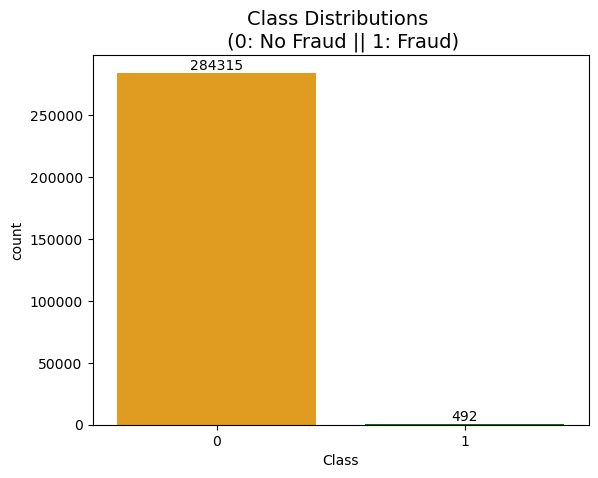

In [6]:
def plot_samples(df, title="Class Distributions"):
    colors = ["orange", "green" ]#["#0101DF", "#DF0101"]
    print("data size is {}".format(df.shape))
    ax = sns.countplot(x='Class', data=df, palette=colors)
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(f'{title} \n (0: No Fraud || 1: Fraud)', fontsize=14)

    plt.show()

plot_samples(df)

### Data Balancing

In [7]:
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

In [8]:
import numpy as np
from sklearn.utils import check_random_state

SEED = 12345

# The NumPy Generator will be used throughout the whole experiment
# rng = np.random.default_rng(SEED)
np.random.seed(SEED)
rng = check_random_state(SEED)

In [9]:
from sklearn.model_selection import train_test_split

X, y = df[df.columns[df.columns != "Class"]], df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, 
                                                    random_state=rng)

##### Feature Scaling

In [10]:
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

# (Selected) Feature Scaling
preprocessing = ColumnTransformer([("scaler", RobustScaler(), ["Time", "Amount"]),],
                                  remainder="passthrough")

In [11]:
X_train_scaled = preprocessing.fit_transform(X_train)
X_test_scaled  = preprocessing.transform(X_test)

#### Under sampling: Near Miss

In [12]:
# Under Sampling Strategy
nm = NearMiss(sampling_strategy="majority", version=3, n_neighbors_ver3=5)
X_train_scaled_sampled, y_train_sampled = nm.fit_resample(X_train_scaled, y_train)

In [13]:
X_train_scaled_sampled.shape, y_train_sampled.shape

((788, 30), (788,))

In [14]:
X_train_scaled.shape, y_train.shape

((227845, 30), (227845,))

In [15]:
y_train[y_train == 1].shape

(394,)

In [16]:
y_train_sampled[y_train_sampled==0].shape == y_train_sampled[y_train_sampled==1].shape

True

In [17]:
df_sampled_nm = pd.DataFrame(X_train_scaled_sampled, columns=X_train.columns)
df_sampled_nm["Class"] = y_train_sampled

df_sampled_nm.shape

(788, 31)

data size is (788, 31)


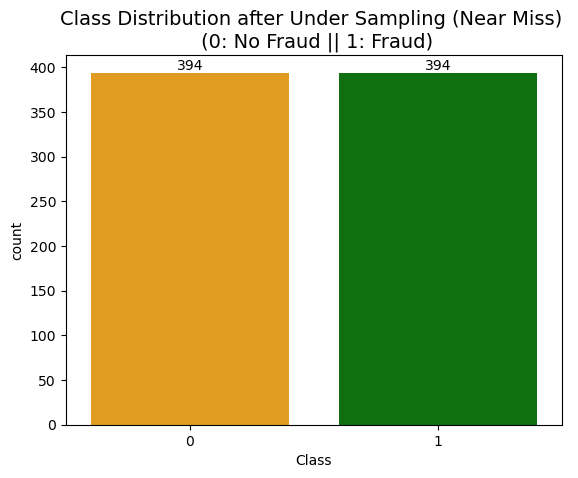

In [18]:
plot_samples(df_sampled_nm, title="Class Distribution after Under Sampling (Near Miss)")

#### Over sampling: SMOTE

In [19]:
# Over Sampling Strategies
smote = SMOTE(sampling_strategy="minority", random_state=rng)
X_train_scaled_sampled, y_train_sampled = smote.fit_resample(X_train_scaled, y_train)

In [20]:
X_train_scaled_sampled.shape, y_train_sampled.shape

((454902, 30), (454902,))

In [21]:
X_train_scaled.shape, y_train.shape

((227845, 30), (227845,))

In [22]:
y_train[y_train == 1].shape

(394,)

In [23]:
y_train_sampled[y_train_sampled==0].shape == y_train_sampled[y_train_sampled==1].shape

True

In [24]:
df_sampled_smote = pd.DataFrame(X_train_scaled_sampled, columns=X_train.columns)
df_sampled_smote["Class"] = y_train_sampled

df_sampled_smote.shape

(454902, 31)

data size is (454902, 31)


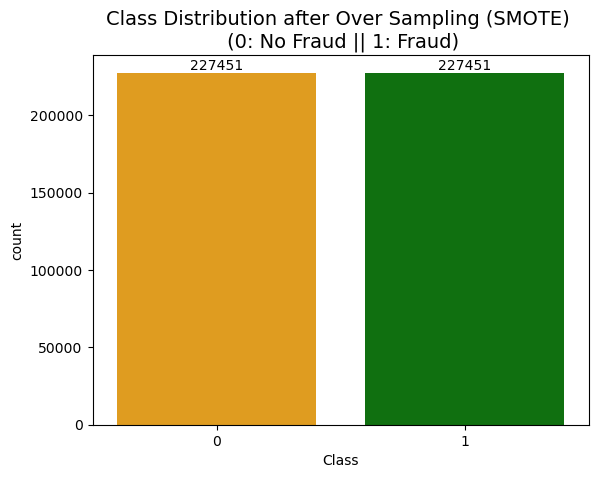

In [25]:
plot_samples(df_sampled_smote, title="Class Distribution after Over Sampling (SMOTE)")

### Feature Importance

In [26]:
import numpy as np

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer

In [27]:
best_feature_count =5

KBestScores = SelectKBest(score_func=f_classif, k=best_feature_count).fit(X_train, y_train)

# summarize scores
np.set_printoptions(precision=3)

print ("scores_:", KBestScores.scores_)
print ("selected index:",KBestScores.get_support(True))



feat_names = df.columns.values[KBestScores.get_support(True)]
indices = np.argsort(KBestScores.scores_)[::-1]
print ("selected features {}" .format(feat_names)  )

scores_: [3.164e+01 2.394e+03 1.864e+03 9.035e+03 4.210e+03 1.996e+03 4.735e+02
 8.229e+03 9.083e+01 2.290e+03 1.171e+04 5.852e+03 1.765e+04 4.795e+00
 2.390e+04 2.971e+00 9.503e+03 2.854e+04 3.002e+03 2.752e+02 9.688e+01
 3.274e+02 1.160e+00 7.101e+00 1.230e+01 1.702e+00 3.844e+00 6.614e+01
 3.174e+01 9.881e+00]
selected index: [10 12 14 16 17]
selected features ['V10' 'V12' 'V14' 'V16' 'V17']


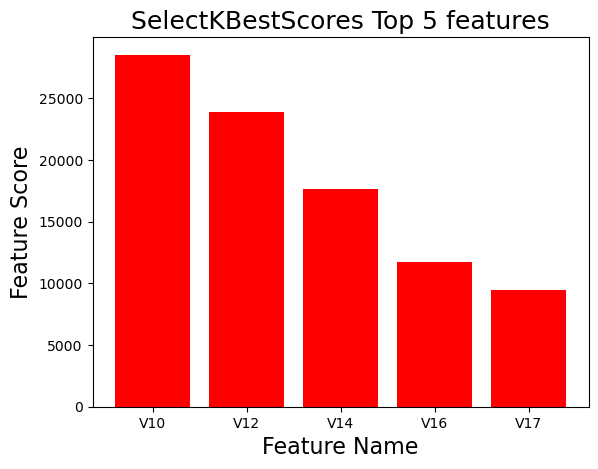

In [28]:
plt.figure()
plt.title('SelectKBestScores Top 5 features', fontsize=18)
plt.xlabel('Feature Name', fontsize=16)
plt.ylabel('Feature Score', fontsize=16)
plt.bar(feat_names, KBestScores.scores_[indices[range(best_feature_count)]], color='r', align='center')
plt.show()